# Price Predictor Linear Regression Model

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
from config import db_password

## Load in data

In [2]:
# database address
host_name = 'database-1.cvhixt1fojqo.us-east-1.rds.amazonaws.com'

In [3]:
# create the database engine
db_string = f"postgresql://postgres:{db_password}@{host_name}:5432/Crypto_Data"

In [4]:
engine = create_engine(db_string)

In [9]:
ada_df = pd.read_sql("SELECT * FROM crypto_orig", con=engine)

In [10]:
ada_df.shape

(5012, 9)

In [11]:
ada_df.dtypes

type_crypto       object
date_orig         object
daystarttoend      int64
open_            float64
high_            float64
low_             float64
close_           float64
volume_          float64
marketcap_       float64
dtype: object

In [12]:
ada_df.tail()

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_
5007,xrp,2022-04-22,1664,0.732871,0.737977,0.716050,0.719207,2.627855e+09,3.355920e+10
5008,xrp,2022-04-23,1665,0.718315,0.725091,0.707839,0.707839,2.164639e+09,3.293130e+10
5009,xrp,2022-04-24,1666,0.706665,0.712171,0.698350,0.698653,1.459710e+09,3.258883e+10
5010,xrp,2022-04-25,1667,0.698746,0.698746,0.648551,0.695372,2.543621e+09,3.106676e+10
5011,xrp,2022-04-26,1668,0.693388,0.704096,0.634284,0.640324,2.831844e+09,3.106295e+10


## Transform datatypes

In [13]:
ada_df['date_orig'] = pd.to_datetime(ada_df["date_orig"])
ada_df.dtypes

type_crypto              object
date_orig        datetime64[ns]
daystarttoend             int64
open_                   float64
high_                   float64
low_                    float64
close_                  float64
volume_                 float64
marketcap_              float64
dtype: object

## Visualize Data

In [14]:
plt.plot(ada_df.date_orig, ada_df.close_ada)
plt.xlabel('Date')
plt.ylabel('EOD Close Price in USD')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'close_ada'

## Adding in target variable

The target variable in this case will be the close price after one year for each piece of data

In [15]:
# intialize time delta for prediction
dt_days = 30

In [16]:
# initialize dt column for how far we want to predict
ada_df['date_pred'] = ada_df['date_orig'] + timedelta(days=dt_days)
ada_df.tail()

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_,date_pred
5007,xrp,2022-04-22,1664,0.732871,0.737977,0.716050,0.719207,2.627855e+09,3.355920e+10,2022-05-22
5008,xrp,2022-04-23,1665,0.718315,0.725091,0.707839,0.707839,2.164639e+09,3.293130e+10,2022-05-23
5009,xrp,2022-04-24,1666,0.706665,0.712171,0.698350,0.698653,1.459710e+09,3.258883e+10,2022-05-24
5010,xrp,2022-04-25,1667,0.698746,0.698746,0.648551,0.695372,2.543621e+09,3.106676e+10,2022-05-25
5011,xrp,2022-04-26,1668,0.693388,0.704096,0.634284,0.640324,2.831844e+09,3.106295e+10,2022-05-26


In [17]:
# create a copy dataframe to pull target close price
ada_df_copy = ada_df.copy()
ada_df_copy.head()

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_,date_pred
0,ada,2017-10-02,1,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,2017-11-01
1,ada,2017-10-03,2,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,2017-11-02
2,ada,2017-10-04,3,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,2017-11-03
3,ada,2017-10-05,4,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,2017-11-04
4,ada,2017-10-06,5,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,2017-11-05


In [18]:
# merge dataframes to get target variable
# JOIN TABLES
ada_df_clean = ada_df.merge(ada_df_copy, how='left', left_on='date_pred', right_on='date_orig', suffixes=(None, '_pred'))
ada_df_clean.tail()

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open__pred,high__pred,low__pred,close__pred,volume__pred,marketcap__pred,date_pred_pred
14835,xrp,2022-04-22,1664,0.732871,0.737977,0.716050,0.719207,2.627855e+09,3.355920e+10,2022-05-22,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
14836,xrp,2022-04-23,1665,0.718315,0.725091,0.707839,0.707839,2.164639e+09,3.293130e+10,2022-05-23,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
14837,xrp,2022-04-24,1666,0.706665,0.712171,0.698350,0.698653,1.459710e+09,3.258883e+10,2022-05-24,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
14838,xrp,2022-04-25,1667,0.698746,0.698746,0.648551,0.695372,2.543621e+09,3.106676e+10,2022-05-25,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
14839,xrp,2022-04-26,1668,0.693388,0.704096,0.634284,0.640324,2.831844e+09,3.106295e+10,2022-05-26,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [19]:
ada_df_clean.tail(50)

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open__pred,high__pred,low__pred,close__pred,volume__pred,marketcap__pred,date_pred_pred
14790,xrp,2022-03-21,1632,0.805629,0.849468,0.792264,0.837429,2.274470e+09,3.762871e+10,2022-04-20,eth,2022-04-20,1662.0,3106.904200,3164.575600,3048.144686,3083.575790,2.437321e+10,3.730000e+11,2022-05-20
14791,xrp,2022-03-21,1632,0.805629,0.849468,0.792264,0.837429,2.274470e+09,3.762871e+10,2022-04-20,xrp,2022-04-20,1662.0,0.774822,0.774822,0.744860,0.752079,2.228832e+09,3.512701e+10,2022-05-20
14792,xrp,2022-03-22,1633,0.837872,0.862129,0.829606,0.836846,3.405606e+09,3.890069e+10,2022-04-21,ada,2022-04-21,1663.0,0.936793,0.969606,0.896279,0.909827,1.059532e+09,2.967070e+10,2022-05-21
14793,xrp,2022-03-22,1633,0.837872,0.862129,0.829606,0.836846,3.405606e+09,3.890069e+10,2022-04-21,eth,2022-04-21,1663.0,3083.140930,3179.755400,2963.802813,2994.364500,2.804015e+10,3.720000e+11,2022-05-21
14794,xrp,2022-03-22,1633,0.837872,0.862129,0.829606,0.836846,3.405606e+09,3.890069e+10,2022-04-21,xrp,2022-04-21,1663.0,0.752022,0.765283,0.725694,0.732554,2.274565e+09,3.464183e+10,2022-05-21
14795,xrp,2022-03-23,1634,0.836761,0.844157,0.820353,0.837493,2.603903e+09,3.829368e+10,2022-04-22,ada,2022-04-22,1664.0,0.909063,0.923691,0.894321,0.907236,1.201371e+09,2.867515e+10,2022-05-22
14796,xrp,2022-03-23,1634,0.836761,0.844157,0.820353,0.837493,2.603903e+09,3.829368e+10,2022-04-22,eth,2022-04-22,1664.0,2990.015000,3027.822900,2946.740744,2972.362400,3.354366e+10,3.600000e+11,2022-05-22
14797,xrp,2022-03-23,1634,0.836761,0.844157,0.820353,0.837493,2.603903e+09,3.829368e+10,2022-04-22,xrp,2022-04-22,1664.0,0.732871,0.737977,0.716050,0.719207,2.627855e+09,3.355920e+10,2022-05-22
14798,xrp,2022-03-24,1635,0.837728,0.848995,0.829610,0.842341,2.693237e+09,3.869337e+10,2022-04-23,ada,2022-04-23,1665.0,0.906163,0.910934,0.883990,0.888474,7.555170e+08,2.826530e+10,2022-05-23
14799,xrp,2022-03-24,1635,0.837728,0.848995,0.829610,0.842341,2.693237e+09,3.869337e+10,2022-04-23,eth,2022-04-23,1665.0,2968.008600,2980.159564,2928.951900,2942.909900,2.036705e+10,3.570000e+11,2022-05-23


In [15]:
# drop empty rows
ada_df_pre_final = ada_df_clean.dropna()

In [16]:
# only include relevant features (X) and target variables (y)
ada_df_final = ada_df_pre_final[['open_ada','high_ada','low_ada','close_ada','volume_ada','marketcap_ada','close_ada_pred']]
ada_df_final.head()

,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,close_ada_pred
0,0.024969,0.030088,0.019969,0.025808,8.310030e+07,567275650.8,0.023359
1,0.025671,0.027172,0.020575,0.020827,2.971484e+07,678634914.2,0.021463
2,0.020828,0.022962,0.020828,0.021973,1.243013e+07,569544386.4,0.022775
3,0.022035,0.022245,0.020839,0.021512,7.055960e+06,554868595.8,0.022038
4,0.021286,0.021576,0.018071,0.018481,6.207887e+06,521924570.1,0.021961


## Create features and target

In [17]:
# features
X = ada_df_final.drop('close_ada_pred', axis=1)
X = X.values.reshape(-1,6)
X

array([[2.49695000e-02, 3.00877000e-02, 1.99693000e-02, 2.58084020e-02,
        8.31003000e+07, 5.67275651e+08],
       [2.56711360e-02, 2.71715620e-02, 2.05754950e-02, 2.08268640e-02,
        2.97148435e+07, 6.78634914e+08],
       [2.08280050e-02, 2.29620980e-02, 2.08280050e-02, 2.19732450e-02,
        1.24301341e+07, 5.69544386e+08],
       ...,
       [1.13135473e+00, 1.16403508e+00, 1.08118455e+00, 1.10002414e+00,
        3.78182262e+09, 3.52877064e+10],
       [1.09716868e+00, 1.15603710e+00, 1.08306297e+00, 1.15423499e+00,
        2.37553005e+09, 3.53656257e+10],
       [1.15324961e+00, 1.18453434e+00, 1.11013411e+00, 1.18325630e+00,
        1.59121490e+09, 3.58653684e+10]])

In [18]:
# target
y = ada_df_final['close_ada_pred']
y

0       0.023359
1       0.021463
2       0.022775
3       0.022038
4       0.021961
          ...   
1633    0.907236
1634    0.888474
1635    0.885290
1636    0.898860
1637    0.824140
Name: close_ada_pred, Length: 1638, dtype: float64

## Linear Regression Model

In [19]:
# initialize class for linear reg algorithms
model = LinearRegression()

In [20]:
# fit or train the data
model.fit(X,y)

LinearRegression()

In [21]:
# predict outcomes before current date
y_pred = model.predict(X)
print(y_pred.shape)

(1638,)


In [22]:
# slope
print(model.coef_)
# y-int
print(model.intercept_)

[ 3.68966570e-02 -1.54012615e+00 -6.14877471e-01  1.14798666e+00
  2.05218204e-11  5.92215166e-11]
0.08713361177760176


## Visualize Outcome

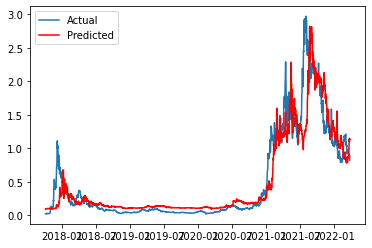

In [23]:
# display y_predictions based on the lin reg
# TABLEAU VISUALIZATION
plt.plot(ada_df_pre_final.date_orig, y)
plt.plot(ada_df_pre_final.date_orig, y_pred, color='red')
plt.legend(["Actual", "Predicted"])
plt.show()

## Test Data (predicting the future)

In [24]:
ada_df_clean.tail()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open_ada_pred,high_ada_pred,low_ada_pred,close_ada_pred,volume_ada_pred,marketcap_ada_pred,date_pred_pred
1663,ada,2022-04-22,1664,0.909063,0.923691,0.894321,0.907236,1.201371e+09,2.867515e+10,2022-05-22,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1664,ada,2022-04-23,1665,0.906163,0.910934,0.883990,0.888474,7.555170e+08,2.826530e+10,2022-05-23,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1665,ada,2022-04-24,1666,0.887093,0.897949,0.880130,0.885290,5.521224e+08,2.800958e+10,2022-05-24,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1666,ada,2022-04-25,1667,0.885730,0.899764,0.830142,0.898860,1.175064e+09,2.721793e+10,2022-05-25,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1667,ada,2022-04-26,1668,0.897602,0.900668,0.819120,0.824140,1.311330e+09,2.730421e+10,2022-05-26,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [32]:
ada_df_test = ada_df_clean.loc[pd.isna(ada_df_clean["type_crypto_pred"]), :]
ada_df_test.head()

,type_crypto,date_orig,daystarttoend,open_ada,high_ada,low_ada,close_ada,volume_ada,marketcap_ada,date_pred,type_crypto_pred,date_orig_pred,daystarttoend_pred,open_ada_pred,high_ada_pred,low_ada_pred,close_ada_pred,volume_ada_pred,marketcap_ada_pred,date_pred_pred
1638,ada,2022-03-28,1639,1.183179,1.241308,1.163463,1.163463,2.386889e+09,3.770805e+10,2022-04-27,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1639,ada,2022-03-29,1640,1.169809,1.238403,1.169809,1.191059,2.679538e+09,3.789108e+10,2022-04-28,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1640,ada,2022-03-30,1641,1.190818,1.215848,1.165334,1.192068,1.981183e+09,3.744125e+10,2022-04-29,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1641,ada,2022-03-31,1642,1.190039,1.225445,1.138841,1.143414,1.929616e+09,3.732850e+10,2022-04-30,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1642,ada,2022-04-01,1643,1.142448,1.173459,1.109309,1.164360,2.363333e+09,3.612519e+10,2022-05-01,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [33]:
X_test = ada_df_test[['open_ada','high_ada','low_ada','close_ada','volume_ada','marketcap_ada']]
X_test = X_test.values.reshape(-1,6)
X_test

array([[1.18317894e+00, 1.24130844e+00, 1.16346303e+00, 1.16346303e+00,
        2.38688925e+09, 3.77080508e+10],
       [1.16980890e+00, 1.23840334e+00, 1.16980890e+00, 1.19105866e+00,
        2.67953818e+09, 3.78910816e+10],
       [1.19081752e+00, 1.21584822e+00, 1.16533420e+00, 1.19206765e+00,
        1.98118286e+09, 3.74412520e+10],
       [1.19003933e+00, 1.22544537e+00, 1.13884146e+00, 1.14341396e+00,
        1.92961615e+09, 3.73285023e+10],
       [1.14244753e+00, 1.17345913e+00, 1.10930946e+00, 1.16435969e+00,
        2.36333250e+09, 3.61251897e+10],
       [1.16484361e+00, 1.19443598e+00, 1.15153525e+00, 1.15754056e+00,
        1.74312197e+09, 3.69722830e+10],
       [1.15662228e+00, 1.19834321e+00, 1.14666141e+00, 1.18581126e+00,
        1.35913997e+09, 3.68986313e+10],
       [1.18600844e+00, 1.23250965e+00, 1.16643708e+00, 1.21266547e+00,
        2.09777841e+09, 3.77103759e+10],
       [1.21353595e+00, 1.21783128e+00, 1.16935079e+00, 1.17180778e+00,
        2.29923450e+09, 

In [34]:
# predict outcomes before current date
y_pred_future = model.predict(X_test)
print(y_pred_future.shape)

(30,)


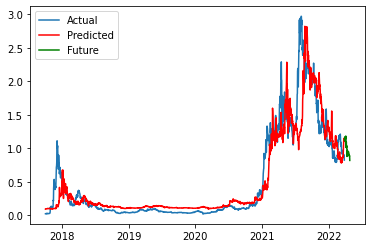

In [35]:
# display y_predictions based on the lin reg
plt.plot(ada_df_pre_final.date_orig, y)
plt.plot(ada_df_pre_final.date_orig, y_pred, color='red')
plt.plot(ada_df_test.date_orig, y_pred_future, color='green')
plt.legend(["Actual", "Predicted", 'Future'])
plt.show()

## Creating Output Dataframe

In [62]:
close_pred_series = pd.Series(y_pred).append(pd.Series(y_pred_future))
close_pred_df = pd.DataFrame(close_pred_series, columns=['close'])
close_pred_df.reset_index(inplace=True)
close_pred_df

,index,close
0,0,0.094365
1,1,0.098290
2,2,0.098940
3,3,0.098574
4,4,0.095831
...,...,...
1663,25,0.912511
1664,26,0.883443
1665,27,0.882139
1666,28,0.891510


In [65]:
crypto_30_day_df = pd.DataFrame(ada_df_clean['type_crypto'])
crypto_30_day_df['date_orig'] = ada_df_clean['date_orig']
crypto_30_day_df['close_orig'] = ada_df_clean['close_ada']
crypto_30_day_df['date_pred_30_day'] = ada_df_clean['date_pred']
crypto_30_day_df['close_pred_30_day'] = close_pred_df['close']
len(crypto_30_day_df)

1668

In [66]:
crypto_30_day_df

,type_crypto,date_orig,close_orig,date_pred_30_day,close_pred_30_day
0,ada,2017-10-02,0.025808,2017-11-01,0.094365
1,ada,2017-10-03,0.020827,2017-11-02,0.098290
2,ada,2017-10-04,0.021973,2017-11-03,0.098940
3,ada,2017-10-05,0.021512,2017-11-04,0.098574
4,ada,2017-10-06,0.018481,2017-11-05,0.095831
...,...,...,...,...,...
1663,ada,2022-04-22,0.907236,2022-05-22,0.912511
1664,ada,2022-04-23,0.888474,2022-05-23,0.883443
1665,ada,2022-04-24,0.885290,2022-05-24,0.882139
1666,ada,2022-04-25,0.898860,2022-05-25,0.891510
